In [1]:
%pylab inline
import pickle
import numpy as np
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


In [2]:
def hmf_weighted(fluxes, ivars, j, num_iter=20, load=False, filestring_a='', filestring_b='', curr_iter=0):
    """
    TODO: docstring
    """
    # ensures that the number of nonzero observations must be 5x 
    # the number of vectors, j=nvec
    # fluxes, ivars = enough_obs(fluxes, ivars, min_spectra=j*10)
    
    if not load:
        S = fluxes.T # with dimensions S[nwave, nspec]
        W = ivars.T # the weights matrix with dimensions W[nwave, nspec]
        V = np.random.rand(S.shape[0], j)
        C = np.zeros((j, S.shape[1]))

    else:
        if (not filestring_a) or (not filestring_b):
            print('error: please pass in the correct filestrings to load V and C model components')
            return            
        V, C = load_arrays(filestring_a, filestring_b)
        S = fluxes.T # with dimensions S[nwave, nspec]
        W = ivars.T # weights matrix with dims W[nwave, nspec]

    # track chi stat over time
    chistats = np.zeros((num_iter,))
    
    # iterate
    i = curr_iter
    while(i < num_iter): #TODO: Legit Stopping condition
        C = solveCoeffs(S, W, V, C)
        V = solveEigvecs(S, W, V, C)
        
        # evaluate model
        chi_stat = eval_model(S, W, V, C)
        print('chi stat is {}'.format(chi_stat), flush=True)
        chistats = np.append(chistats, chi_stat)

        # dump files to disk
        with open("./hmf_templates/model_V_iter_{}.pkl".format(i),"wb") as file:
            pickle.dump(V,file)
    
        with open("./hmf_templates/model_C_iter_{}.pkl".format(i), "wb") as file:
            pickle.dump(C, file)
        
        i+=1
    C = solveCoeffs(S, W, V, C) # solve coeffs one last time
    return V, C, chistats


In [3]:
def solveCoeffs(S, W, V, C):
    """
    TODO: docstring
    """
    A = np.zeros((C.shape[1], C.shape[0], C.shape[0]))    
    b = np.zeros((C.shape[1], C.shape[0]))
    
    output_cached_mat = np.zeros((C.shape[0], V.shape[0]))
    
    for i in range(C.shape[1]): # iterate over all rows of S
        spec_i = S[:, i]
        D = np.diag(W[:, i]) # diagonal matrix of weights corresponding to spec_i
        
        # V^T * D * spec_i = (V^T * D * V) * coeff[:, i]
        # solver determines x where Ax = b, solve for the coefficients column that corresponds to spec_i
        np.dot(V.T, D, out=output_cached_mat)
        np.dot(output_cached_mat, V, out=A[i])
        np.dot(output_cached_mat, spec_i, out=b[i])
    
    C = np.linalg.solve(A, b).T
    return C

In [4]:
def solveEigvecs(S, W, V, C):
    """
    TODO: docstring
    """
    A = np.zeros((V.shape[0], V.shape[1], V.shape[1]))
    b = np.zeros((V.shape[0], V.shape[1],))
    output_cached_mat = np.zeros((V.shape[1], C.shape[1]))
    
    for lam in range(V.shape[0]): # iterate over all wavelengths
        wave_lam = S[lam, :]
        D = np.diag(W[lam, :])
        
        # C * D * wave_lam = (C * D * C.T) * eigvec[:, j]
        # solver determines x where Ax = b
        np.dot(C, D, out=output_cached_mat)
        np.dot(output_cached_mat, C.T, out=A[lam])
        np.dot(output_cached_mat, wave_lam.T, out=b[lam])
    
    V = np.linalg.solve(A, b) # V[lam] = V[lam, :]
    return V

In [5]:
def eval_model(S, W, V, C):
    """
    Evaluates the model by computing Delta = S - VC 
    and then calculating Chi2 = SUM[W(lam, i) * Delta(lam, i)**2] over all wavelengths lam and spectra i
    """
    Delta = S - np.dot(V, C)
    D_squared = np.multiply(Delta, Delta)
    chi_stat = np.multiply(W, D_squared)
    return np.sum(np.sum(chi_stat))

In [6]:
def load_arrays(filestring_V, filestring_C):
    """
    TODO: docstring
    """
    with open(filestring_V, "rb") as file:
        V = pickle.load(file)
    with open(filestring_C, "rb") as file:
        C = pickle.load(file)
    return V, C

In [7]:
with open("./cleaned_spectra/fluxes_clean.pkl","rb") as file:
    fluxes = pickle.load(file)

with open("./cleaned_spectra/ivars_clean.pkl","rb") as file:
    ivars = pickle.load(file)
    
with open("./cleaned_spectra/restlams_clean.pkl", "rb") as file:
    rest_loglams = pickle.load(file)
    
with open("./cleaned_spectra/wavelengths_clean.pkl", "rb") as file:
    wavelengths = pickle.load(file)
    
qsocat = Table.read("./cleaned_spectra/qsocat_clean.fits")

In [8]:
print(fluxes.shape)

(23396, 12938)


In [9]:
min_per_lam=50
rest_offset = 2.6

In [10]:
with open("./hmf_templates/fluxes.pkl","wb") as file:
    pickle.dump(fluxes, file)

with open("./hmf_templates/ivars.pkl","wb") as file:
    pickle.dump(ivars, file)

with open("./hmf_templates/rest_loglams.pkl","wb") as file:
    pickle.dump(rest_loglams, file)

with open("./hmf_templates/wavelengths.pkl","wb") as file:
    pickle.dump(wavelengths, file)

qsocat.write('./hmf_templates/qsocat.fits', format='fits', overwrite=True)

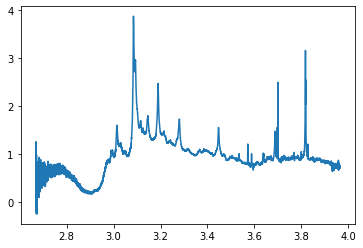

In [11]:
plot(rest_loglams, np.average(fluxes, axis=0, weights=ivars));

In [12]:
%%time
V, C, chistats = hmf_weighted(fluxes, ivars, 10, num_iter=15,)

chi stat is 207414371.76787028
chi stat is 132824630.49096845
chi stat is 129046194.75699441
chi stat is 128083731.4436735
chi stat is 127645739.25247803
chi stat is 127350186.62576103
chi stat is 127129833.0489741
chi stat is 126972607.96353802
chi stat is 126861114.19477546
chi stat is 126778350.28096418
chi stat is 126713487.47121051
chi stat is 126660351.65702108
chi stat is 126615449.23235723
chi stat is 126576707.2074285
chi stat is 126542769.47205774
CPU times: user 3d 21h 31min 14s, sys: 2d 7h 44min 20s, total: 6d 5h 15min 35s
Wall time: 3d 2h 44min 15s


In [13]:
with open("./hmf_templates/model_V.pkl","wb") as file:
    pickle.dump(V,file)

with open("./hmf_templates/model_C.pkl", "wb") as file:
    pickle.dump(C, file)

In [14]:
model = np.dot(V, C).T

In [15]:
rest_loglams.shape

(12938,)

In [16]:
fluxes.shape

(23396, 12938)

In [17]:
model.shape

(23396, 12938)

In [18]:
with open("./hmf_templates/model_hmf.pkl", "wb") as file:
    pickle.dump(model, file)

In [19]:
max(rest_loglams)

3.965

In [20]:
max(wavelengths)

9225.71427154763

In [21]:
min(qsocat['Z'])

0.03451842814683914

In [22]:
qsocat['Z'][50]

0.1130116730928421